In [1]:
import networkx as nx
import numpy as np
import pylab as plt
import re
import sys
from collections import defaultdict, Counter
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi
import matplotlib.cm as cm
# read in the edge list


In [3]:
e=[]
with open('edges.txt','r') as f:
    for line in f:
        i,j,w=map(int,line.strip().split('\t'))
        e.append([i,j,w])
    

In [4]:
name={}
with open('nodes.txt','r', encoding='latin1') as f:
    for line in f:
        i,j=line.strip().split('\t')
        j=j.replace('"','')
        name[int(i)]=j

In [5]:
K=defaultdict(lambda:0)
for i,j,w in e:
    K[i]+=w
    K[j]+=w
len(K),len(e)

(3104, 26183)

In [6]:
#m2=sum(K.values())
E=[]
for i,j,w in e:
    ki=K[i]
    kj=K[j]
   # if w>ki*kj/m2:
    #if w>mK:
    E.append([i,j]) 
G=nx.Graph()
G.add_edges_from(E)

In [7]:
dists = []
p=nx.shortest_path_length(G)
nodes=G.nodes()
for i in p:
    vs=[p[i][j] for j in nodes]
    dists.append(vs)

In [8]:
rawadist=np.array(dists)
adist = np.array(dists)
amax = np.amax(adist)
adist = adist/float(amax)
adist.shape

(3104, 3104)

In [9]:
coords= MDS(n_components=2, dissimilarity="precomputed", random_state=6).fit_transform(adist)
#coords = TSNE(n_components=2,metric="precomputed").fit_transform(adist)
dic=dict((i,j) for i,j in zip(nodes,coords)) 

In [10]:
X=np.array(list(dic.values()))
Ncluster=3  # CHANGE THE NUMBER OF CLUSTERS HERE
kmeans = KMeans(n_clusters=Ncluster, random_state=0).fit(X)
pos={}
for i,l in zip(list(dic.keys()),kmeans.labels_):
    x,y=dic[i]
    k=K[i]
    pos[i]=[x,y,k,l]

In [11]:
np.percentile(list(K.values()),97),0.03*3000 # TO DISPLAY ONLY TOP 3% OF LABELS

(1714.0299999999952, 90.0)

In [81]:
Pos=pos

In [73]:
# SAVE COORDINATES
coord = "coord.txt"
co = open(coord, "w",encoding='latin1')
for key in Pos.items():
    co.write(str(key[0]) + '\t'+ str(key[1][0]) + '\t'+ str(key[1][1])+ '\t' + str(key[1][2]) + '\t'+ str(key[1][3])+'\n')
co.close()
    

In [11]:
def voronoi_finite_polygons_2d(vor, radius=None):
        # from https://gist.github.com/pv/8036995
        if vor.points.shape[1] != 2:
            raise ValueError("Requires 2D input")
        new_regions = []
        new_vertices = vor.vertices.tolist()
        center = vor.points.mean(axis=0)
        if radius is None:
            radius = vor.points.ptp().max()
        # Construct a map containing all ridges for a given point
        all_ridges = {}
        for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
            all_ridges.setdefault(p1, []).append((p2, v1, v2))
            all_ridges.setdefault(p2, []).append((p1, v1, v2))
        # Reconstruct infinite regions
        for p1, region in enumerate(vor.point_region):
            vertices = vor.regions[region]
            if all(v >= 0 for v in vertices):
                # finite region
                new_regions.append(vertices)
                continue
            # reconstruct a non-finite region
            ridges = all_ridges[p1]
            new_region = [v for v in vertices if v >= 0]
            for p2, v1, v2 in ridges:
                if v2 < 0:
                    v1, v2 = v2, v1
                if v1 >= 0:
                    # finite ridge: already in the region
                    continue
                # Compute the missing endpoint of an infinite ridge
                t = vor.points[p2] - vor.points[p1] # tangent
                t /= np.linalg.norm(t)
                n = np.array([-t[1], t[0]])  # normal
                midpoint = vor.points[[p1, p2]].mean(axis=0)
                direction = np.sign(np.dot(midpoint - center, n)) * n
                far_point = vor.vertices[v2] + direction * radius
                new_region.append(len(new_vertices))
                new_vertices.append(far_point.tolist())
            # sort region counterclockwise
            vs = np.asarray([new_vertices[v] for v in new_region])
            c = vs.mean(axis=0)
            angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
            new_region = np.array(new_region)[np.argsort(angles)]
            # finish
            new_regions.append(new_region.tolist())
 #       print(len(new_region))
        return new_regions, np.asarray(new_vertices)

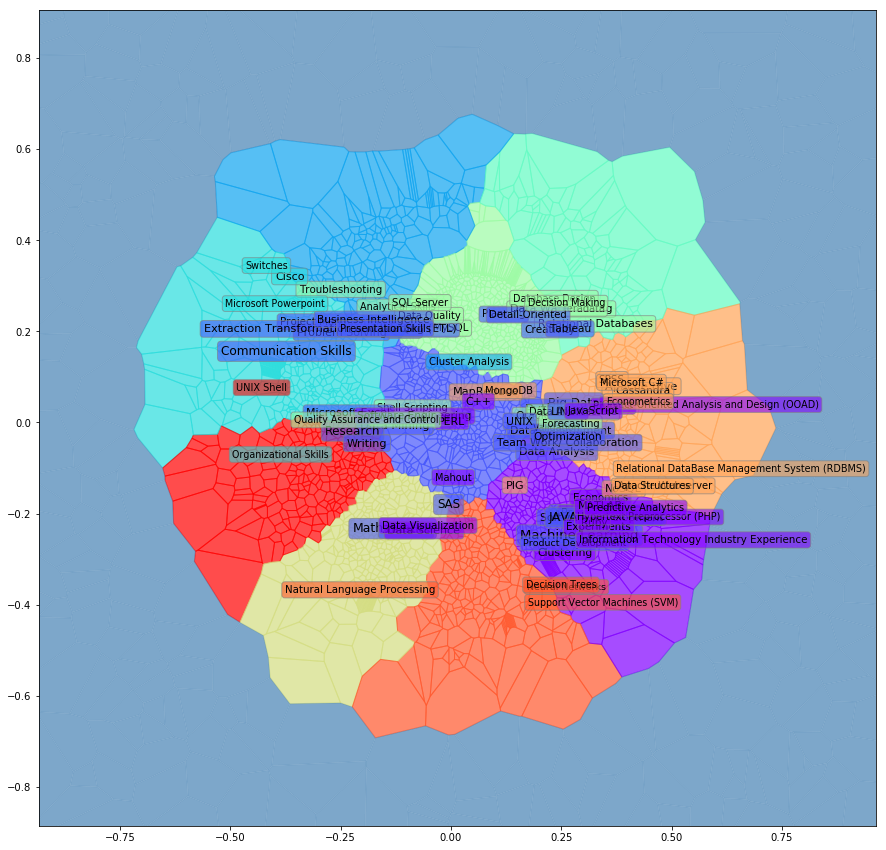

In [82]:
nodeClusterLabel=dict((k,v[-1]) for k,v in list(Pos.items()))
pos=dict((k,v[:2]) for k,v in list(Pos.items()))
allPoints = pos.copy() #allPoints to include other types of points in future
# generate dots on the edge and merge into allpoints
r=0.16;N=600;rs=[]
#r=1;N=500;rs=[] # layout 1. N - # point around continent (in blue ocean) 2. r - edge to connect island 
x,y=list(zip(*list(pos.values())))
xmin,xmax=min(x),max(x)
ymin,ymax=min(y),max(y)
k=2 # allow for ocean space (k*r) but r is only for islands
xmax+=k*r;ymax+=k*r;xmin-=k*r;ymin-=k*r
t=np.hstack([np.random.uniform(xmin,xmax,size=(N,1)),np.random.uniform(ymin,ymax,size=(N,1))])
mins=np.array([min([np.linalg.norm(i-j) for j in list(pos.values())]) for i in t])
t=t[mins>r]
surroundPoints=dict(('surroundXXX'+str(n),list(k)) for n,k in enumerate(t))
# genterate retangle-shape points around nodes
n=5
rectPoints={}
rectPointsCluster={}
m=0
for i in pos:
    x,y=pos[i]
    k=Pos[i][2]
    l=k/50.0+0.02
    xs=np.random.uniform(x-l,x+l,n)
    ys=np.random.uniform(y-l,y+l,n)
    cos=list(zip(list(xs)+list(xs),[y-l]*n+[y+l]*n))+list(zip([x-l]*n+[x+l]*n,list(ys)+list(ys)))
    for p in cos:
        rectPoints['rectXXX'+str(m)]=p
        rectPointsCluster['rectXXX'+str(m)]=nodeClusterLabel[i]
        m+=1
#
allPoints.update(surroundPoints)
#allPoints.update(rectPoints)
regions, vertices = voronoi_finite_polygons_2d(Voronoi(list(allPoints.values())))
Regions=dict(list(zip(list(allPoints.keys()),regions)))
Vertices = dict(list(zip(list(range(len(vertices))),vertices)))
#
gs=list(set([Pos[i][-1] for i in Pos]))
cmap = cm.get_cmap('rainbow',len(gs))
fig = plt.figure(figsize=(15, 15),facecolor='white')
ax = fig.add_subplot(111)
maxK=max([Pos[i][2] for i in Pos])+0.0
#for j in pos:
    #x,y=pos[j]
    #k=Pos[j][2]/maxK
    #plt.text(x,y,str(j),fontsize=k*100,va='center',ha='center')
    #plt.text(x,y,str(j),fontsize=10,va='center',ha='center')
    #plt.scatter(x,y,s=10)
    #if k>200:
    #    plt.text(x,y,str(j),fontsize=k/50.0+3,va='center',ha='center')
delta=0.1
for index, (label, (x, y)) in enumerate(pos.items()):
    k=K[label]
    ###
   ## out.write(index + "\t" + x + "\t" + y)
    ###
    try:
        if k>1744:  # TO REMOVE LABELS SEE WHAT 100% - CHANGE 97 TO 100 np.percentile(list(K.values()),97),0.03*3000
            dx = x - coords[:,0]
            dy = y - coords[:,1]
            dx[index] = 1
            dy[index] = 1
            this_dx = dx[np.argmin(np.abs(dy))]
            this_dy = dy[np.argmin(np.abs(dx))]
            if this_dx > 0:
                ha = 'left'
                x = x + delta
            else:
                ha = 'right'
                x = x - delta
            if this_dy > 0:
                va = 'bottom'
                y = y + delta
            else:
                va = 'top'
                y = y - delta

            plt.text(x, y, name[label], size=np.log(k)+2, ha=ha, va=va, 
                 bbox=dict(facecolor=cmap(nodeClusterLabel[label]), 
                           edgecolor='gray', alpha=.6,boxstyle='round,pad=0.3'))
    except KeyError:
        continue
for i in Regions:
    polygon = np.array([Vertices[j] for j in Regions[i]])
    if 'surroundXXX' in str(i):
        plt.fill(*list(zip(*polygon)), alpha=0.7,facecolor='SteelBlue',edgecolor='none')
        plt.fill(*list(zip(*polygon)), facecolor='none',edgecolor='SteelBlue',alpha=0.1)
    elif 'rectXXX' in str(i): 
        plt.fill(*list(zip(*polygon)), alpha=0.7,facecolor=cmap(gs.index(rectPointsCluster[i])),edgecolor='none')
        plt.fill(*list(zip(*polygon)), facecolor='none',edgecolor=cmap(gs.index(rectPointsCluster[i])),alpha=0.1)
    else:
        plt.fill(*list(zip(*polygon)), alpha=0.7,color=cmap(gs.index(nodeClusterLabel[i])))
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
#
plt.savefig('cluster.png')
plt.show()